# Logistic Regression with TensorFlow

In [6]:
!pip install grpcio==1.48.2
!pip install tensorflow==2.9.1
!pip install --upgrade --force-reinstall numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 54.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.16 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.15 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.22.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.87 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jax 0.4.33 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.4.33 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pandas-gbq 0.23.2 requires google-auth-oauthlib>=0.7.0, but you have googl

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
if not tf.__version__ == '2.9.1':
    print(tf.__version__)
    raise ValueError('please upgrade to TensorFlow 2.9.1, or restart your Kernel (Kernel->Restart & Clear Output)')

### Loading the Iris Dataset

In [3]:
iris = load_iris()
iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]
iris_y= pd.get_dummies(iris_y).values
trainX, testX, trainY, testY = train_test_split(iris_X, iris_y, test_size=0.33, random_state=42)

In [4]:
# numFeatures is the number of features in our input data.
# In the iris dataset, this number is '4'.
numFeatures = trainX.shape[1]
print('numFeatures is : ', numFeatures )
# numLabels is the number of classes our data points can be in.
# In the iris dataset, this number is '3'.
numLabels = trainY.shape[1]
print('numLabels is : ', numLabels )

#X = tf.Variable( np.identity(numFeatures), tf.TensorShape(numFeatures),dtype='float32') # Iris has 4 features, so X is a tensor to hold our data.
#yGold = tf.Variable(np.array([1,1,1]),shape=tf.TensorShape(numLabels),dtype='float32') # This will be our correct answers matrix for 3 classes.

numFeatures is :  4
numLabels is :  3


In [5]:
trainX = tf.constant(trainX, dtype='float32')
trainY = tf.constant(trainY, dtype='float32')
testX = tf.constant(testX, dtype='float32')
testY = tf.constant(testY, dtype='float32')

### Setting the Model Weights and Biases

In [6]:
W = tf.Variable(tf.zeros([4, 3]))  # 4-dimensional input and  3 classes
b = tf.Variable(tf.zeros([3])) # 3-dimensional output [0,0,1],[0,1,0],[1,0,0]

In [7]:
#Randomly sample from a normal distribution with standard deviation .01

weights = tf.Variable(tf.random.normal([numFeatures,numLabels],
                                       mean=0.,
                                       stddev=0.01,
                                       name="weights"),dtype='float32')


bias = tf.Variable(tf.random.normal([1,numLabels],
                                    mean=0.,
                                    stddev=0.01,
                                    name="bias"))


### Logistic Regression


In [8]:
# Three-component breakdown of the Logistic Regression equation.
# Note that these feed into each other.
def logistic_regression(x):
    apply_weights_OP = tf.matmul(x, weights, name="apply_weights")
    add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias")
    activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")
    return activation_OP

### Training


In [9]:
# Number of Epochs in our training
numEpochs = 700

# Defining our learning rate iterations (decay)
learningRate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0008,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [10]:
#Defining our cost function - Squared Mean Error
loss_object = tf.keras.losses.MeanSquaredLogarithmicError()
optimizer = tf.keras.optimizers.SGD(learningRate)

In [11]:
# Accuracy metric.
def accuracy(y_pred, y_true):
# Predicted class is the index of the highest score in prediction vector (i.e. argmax).

    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))

    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [12]:
# Optimization process.

def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = logistic_regression(x)
        loss = loss_object(pred, y)
    gradients = g.gradient(loss, [weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

In [13]:
# Initialize reporting variables
display_step = 10
epoch_values = []
accuracy_values = []
loss_values = []
loss = 0
diff = 1
# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in loss %g; convergence."%diff)
        break
    else:
        # Run training step
        run_optimization(trainX, trainY)

        # Report occasional stats
        if i % display_step == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)

            pred = logistic_regression(testX)

            newLoss = loss_object(pred, testY)
            # Add loss to live graphing variable
            loss_values.append(newLoss)

            # Generate accuracy stats on test data
            acc = accuracy(pred, testY)
            accuracy_values.append(acc)


            # Re-assign values for variables
            diff = abs(newLoss - loss)
            loss = newLoss

            #generate print statements
            print("step %d, training accuracy %g, loss %g, change in loss %g"%(i, acc, newLoss, diff))





# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %acc.numpy())




step 0, training accuracy 0.3, loss 0.138498, change in loss 0.138498
step 10, training accuracy 0.3, loss 0.137919, change in loss 0.000579193
step 20, training accuracy 0.3, loss 0.137348, change in loss 0.000571221
step 30, training accuracy 0.3, loss 0.136784, change in loss 0.000563189
step 40, training accuracy 0.3, loss 0.136229, change in loss 0.000555173
step 50, training accuracy 0.3, loss 0.135682, change in loss 0.000547186
step 60, training accuracy 0.3, loss 0.135143, change in loss 0.000539184
step 70, training accuracy 0.3, loss 0.134612, change in loss 0.000531167
step 80, training accuracy 0.3, loss 0.134088, change in loss 0.000523195
step 90, training accuracy 0.3, loss 0.133573, change in loss 0.000515237
step 100, training accuracy 0.3, loss 0.133071, change in loss 0.000502259
step 110, training accuracy 0.3, loss 0.132596, change in loss 0.000474721
step 120, training accuracy 0.3, loss 0.132129, change in loss 0.000467598
step 130, training accuracy 0.3, loss 0

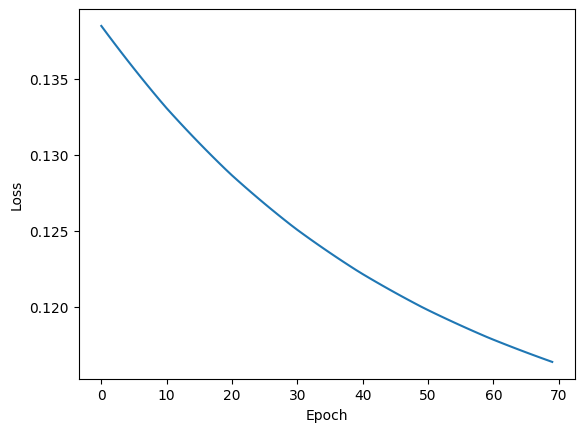

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_values)
plt.show()